In [1]:
import numpy as np
import time
import pickle
import utils as Utils
import pandas as pd
from sklearn import svm
import seaborn as sns
import matplotlib.pyplot as plt
# import modules.model as Model
from matplotlib.backends.backend_pdf import PdfPages
import sklearn.metrics as metrics

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,roc_auc_score,classification_report,roc_curve,auc, f1_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import plotly.graph_objects as go
from imblearn.over_sampling import SMOTE 
# import modules.processor as Processor
# import modules.utils as Utils
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from tqdm import tqdm
import processor as Processor

In [2]:
# !pip3 install xgboost

In [3]:
train_trb = pd.read_csv("./data_final/train_trb.csv")
test_trb = pd.read_csv("./data_final/test_trb.csv")

In [4]:
train_trb_case1_rf_20 = pd.read_csv("./data_final/train_trb_case1_rf_20.csv",)
test_trb_case1_cb_60  = pd.read_csv("./data_final/test_trb_case1_cb_60.csv", )
train_trb_case2_rf_20 = pd.read_csv("./data_final/train_trb_case2_rf_20.csv",)
test_trb_case2_cb_60  = pd.read_csv("./data_final/test_trb_case2_cb_60.csv", )
train_trb_case3_rf_20 = pd.read_csv("./data_final/train_trb_case3_rf_20.csv",)
test_trb_case3_cb_60  = pd.read_csv("./data_final/test_trb_case3_cb_60.csv", )

# Case 01

In [5]:
nm = RandomUnderSampler(random_state=42)
X_res_case1, y_res_case1 = nm.fit_resample(train_trb_case1_rf_20[["CDR3b", "epitope"]], train_trb_case1_rf_20[["binder"]])

In [6]:
X_res_case1.shape, y_res_case1.shape

((22240, 2), (22240, 1))

In [18]:
pX_res_case1 = Processor.data_representation_blosum62(X_res_case1)
py_res_case1 = y_res_case1.copy()

pX_test_rf_case1 = Processor.data_representation_blosum62(test_trb_case1_cb_60)
py_test_rf_case1 = test_trb_case1_cb_60[["binder"]]

pX_test_cb_case1 = Processor.data_representation_blosum62(test_trb)
py_test_cb_case1 = test_trb[["binder"]]

In [20]:
print(pX_res_case1.shape, py_res_case1.shape)
print(pX_test_rf_case1.shape, py_test_rf_case1.shape)
print(pX_test_cb_case1.shape, py_test_cb_case1.shape)

(22240, 600) (22240, 1)
(781623, 600) (781623, 1)
(279997, 600) (279997, 1)


In [33]:
lst_models = [
#     ('Logistic Regression - [solver: lbfgs]', LogisticRegression(solver='lbfgs')),
#     ('Logistic Regression - [solver: liblinear]', LogisticRegression(solver='liblinear')),
#     ('Logistic Regression - [solver: newton-cg]', LogisticRegression(solver='newton-cg')),
#     ('KNN - [n_neighbors: 2]', KNeighborsClassifier(n_neighbors=2)),
#     ('KNN - [n_neighbors: 3]', KNeighborsClassifier(n_neighbors=3)),
#     ('SVC - [kernel: linear]', SVC(kernel='linear', random_state=42)),
#     ('SVC - [kernel: poly]', SVC(kernel='poly', random_state=42)),
#     ('SVC - [kernel: rbf]', SVC(kernel='rbf', random_state=42)),
#     ('SVC - [kernel: sigmoid]', SVC(kernel='sigmoid', random_state=42)),
#     ('Bernoulli', BernoulliNB()),
    ('Random Forest', RandomForestClassifier(random_state=42, n_jobs=-1)),
#     ('XGBoost', XGBClassifier(eval_metric='mlogloss'))
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [36]:
def train(lst_models, X, y, cv):
    res_table = []
    for mdl_name, model in tqdm(lst_models):
        tic = time.time()
        cv_res = cross_validate(model, X, y, cv=cv, return_train_score=True, scoring=['accuracy', 'roc_auc'], n_jobs=-1)
        res_table.append([mdl_name, 
                          cv_res['train_accuracy'].mean(), 
                          cv_res['test_accuracy'].mean(), 
                          np.abs(cv_res['train_accuracy'].mean() - cv_res['test_accuracy'].mean()),
                          cv_res['train_accuracy'].std(),
                          cv_res['test_accuracy'].std(),
                          cv_res['train_roc_auc'].mean(),
                          cv_res['test_roc_auc'].mean(),
                          np.abs(cv_res['train_roc_auc'].mean() - cv_res['test_roc_auc'].mean()),
                          cv_res['train_roc_auc'].std(),
                          cv_res['test_roc_auc'].std(),
                          cv_res['fit_time'].mean()
        ])
        toc = time.time()
        print('\tModel {} has been trained in {:,.2f} seconds'.format(mdl_name, (toc - tic)))
    
    res_table = pd.DataFrame(res_table, columns=['model', 'train_acc', 'test_acc', 'diff_acc',
                                                 'train_acc_std', 'test_acc_std', 'train_roc_auc', 'test_roc_auc',
                                                 'diff_roc_auc', 'train_roc_auc_std', 'test_roc_auc_std', 'fit_time'])
    res_table.sort_values(by=['test_acc', 'test_roc_auc'], ascending=False, inplace=True)

    return res_table.reset_index(drop=True)

In [23]:
original_models = train(lst_models, pX_res_case1, np.ravel(py_res_case1), cv)
original_models

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 1/1 [00:04<00:00,  4.22s/it]

	Model Random Forest has been trained in 4.22 seconds


,model,train_acc,test_acc,diff_acc,train_acc_std,test_acc_std,train_roc_auc,test_roc_auc,diff_roc_auc,train_roc_auc_std,test_roc_auc_std,fit_time
0,Random Forest,0.999989,0.959622,0.040366,0.000022,0.002093,1.0,0.992482,0.007518,0.0,0.001338,0.945741


In [48]:
lst_tunning_models = [
     ('Random Forest', RandomForestClassifier(random_state=42, n_jobs=-1), {
        'bootstrap': [True, False],
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'max_features': ["auto", "sqrt", "log2", 5, 10, 15, 20],
        'min_samples_leaf': [1, 2, 4],
        'n_estimators': [200, 400, 600, 800, 1000]})]

def trainTunningModel(lst_models, X, y, cv):
    models_final = []
    for model_name, model, params in tqdm(lst_models):
        tic     = time.time()
        search = GridSearchCV(estimator=model, param_grid=params, cv=cv, scoring='accuracy', n_jobs=-1)
        search.fit(X, y)
        model_tunned = model.set_params(**search.best_params_)
        models_final.append((model_name, model_tunned))
        toc = time.time()
        print('Model {} has been tunned in {:,.2f} seconds'.format(model_name, (toc - tic)))

    return models_final

In [49]:
lst_tunning_models = trainTunningModel(lst_tunning_models, pX_res_case1, np.ravel(py_res_case1), cv)
lst_tunning_models

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 1/1 [1:29:05<00:00, 5345.91s/it]

Model Random Forest has been tunned in 5,345.91 seconds


In [50]:
lst_tunning_models

In [ ]:
tunning_models = train(lst_tunning_models, pX_res_case1, np.ravel(py_res_case1), cv)
tunning_models

In [42]:
def evaluation(tunning_models, X_train, y_train, X_test, y_test):
    res = []
    for name, model in tqdm(tunning_models):
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        train_roc_auc = roc_auc_score(y_train, y_train_pred)
        test_roc_auc = roc_auc_score(y_test, y_test_pred)
        res.append([name, train_acc, test_acc, train_roc_auc, test_roc_auc])
        
    res = pd.DataFrame(res, columns=['model', 'train_acc', 'test_acc', 'train_roc_auc', 'test_roc_auc'])
    res.sort_values(by=['test_acc', 'test_roc_auc'], ascending=False, inplace=True)
    
    return res.reset_index(drop=True)

In [43]:
best_models = evaluation(lst_tunning_models, pX_res_case1, np.ravel(py_res_case1), pX_test_rf_case1, py_test_rf_case1)
best_models

0it [00:00, ?it/s]


TypeError: 'NoneType' object is not iterable

In [29]:
def confusionMatrix(y_true, y_pred):
    target_names = ['Non-binder', 'Binder']
    print(classification_report(y_true, y_pred, target_names=target_names))
    cm = pd.DataFrame(confusion_matrix(y_true, y_pred), index=target_names, columns=target_names)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion matrix')
    plt.xlabel('Predicted values')
    plt.ylabel('Actual values')
    plt.show()

In [30]:
def model_run(algo, pX_res, py_res, pX_test, py_test):

    algo.fit(pX_res, np.ravel(py_res))
    y_pred = algo.predict(pX_test)
    y_pred_proba = algo.predict_proba(pX_test)[:,1]
    
    accuracy = accuracy_score(py_test, y_pred).ravel()
    classify_metrics = classification_report(py_test, y_pred)
    f1 = f1_score(py_test, y_pred).ravel()
    
    fpr, tpr, thresholds = roc_curve(py_test, y_pred_proba)
    auc_score = auc(fpr, tpr)
    tn, fp, fn, tp = confusion_matrix(py_test, y_pred).ravel()
    confusionMatrix(py_test, y_pred)
    
    print (algo)
    print ("Accuracy score        : ", accuracy)
    print ("F1 score              : ", f1)
    print ("AUC                   : ", auc_score)
    print ('Sensitivity (TPR)     : ', tp/(tp+fn))
    print ('Specificity (TNR)     : ', tn/(tn+fp))
    print ("classification report :\n", classify_metrics)
    
    return accuracy, classify_metrics, fpr , tpr, auc_score, f1

              precision    recall  f1-score   support

  Non-binder       0.91      0.98      0.94    707865
      Binder       0.26      0.06      0.10     73758

    accuracy                           0.89    781623
   macro avg       0.59      0.52      0.52    781623
weighted avg       0.85      0.89      0.86    781623



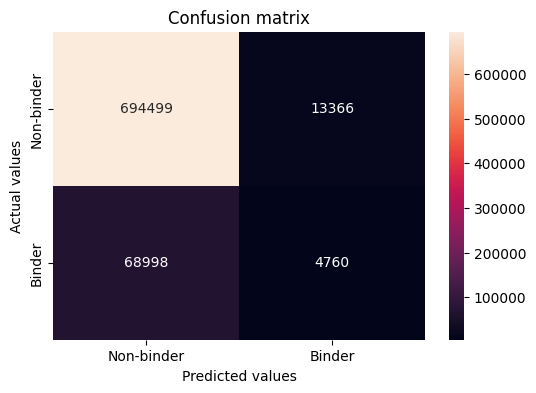

RandomForestClassifier(n_jobs=-1, random_state=42)
Accuracy score        :  [0.89462439]
F1 score              :  [0.1036089]
AUC                   :  0.5958140758679756
Sensitivity (TPR)     :  0.06453537243417663
Specificity (TNR)     :  0.9811178685201274
classification report :
               precision    recall  f1-score   support

           0       0.91      0.98      0.94    707865
           1       0.26      0.06      0.10     73758

    accuracy                           0.89    781623
   macro avg       0.59      0.52      0.52    781623
weighted avg       0.85      0.89      0.86    781623



In [32]:
model_rf = lst_models[0][1]

accuracy, metrics, fpr , tpr, auc_score, f1 = model_run(model_rf, pX_res_case1, py_res_case1, pX_test_rf_case1, py_test_rf_case1)